In [2]:
import os
import geopandas as gpd
import momepy as mm

C:\Users\liche\anaconda3\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-2-384ed68bbafc>:2: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling

In [3]:
buildings = gpd.read_file('src/UKBuildings_Energy.geojson')
boundary = gpd.read_file('src/SiteBoundary.geojson')
boundary = boundary.to_crs('EPSG:27700')

In [4]:
roads = gpd.read_file('src/Highways.gpkg', layer='street')

<AxesSubplot:>

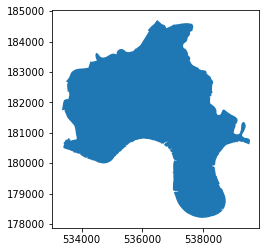

In [5]:
boundary.plot()

In [6]:
roads['uID'] = range(len(roads))

In [10]:
#buildingsExtracted = buildings.dropna(inplace=False)

In [16]:
buildingsExtracted = buildings[(buildings.geometry.area > 10)]

In [17]:
buildingsExtracted['uID'] = range(len(buildingsExtracted))

C:\Users\liche\anaconda3\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [18]:
from shapely.ops import polygonize
from shapely.geometry import Point
import pandas as pd
limit = boundary.geometry

In [19]:
gs = gpd.GeoSeries([limit.boundary.values[0]])

In [20]:
%%time
barriers = pd.concat([roads.geometry, gs])

Wall time: 3 ms


C:\Users\liche\anaconda3\lib\site-packages\geopandas\array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as OSGB36 / British National Grid (the single non-null crs provided).
  warnings.warn(


In [21]:
%%time
unioned = barriers.unary_union

Wall time: 133 ms


In [22]:
%%time
polygons = polygonize(unioned)
enclosures = gpd.array.from_shapely(list(polygons), crs=roads.crs)

Wall time: 205 ms


<AxesSubplot:>

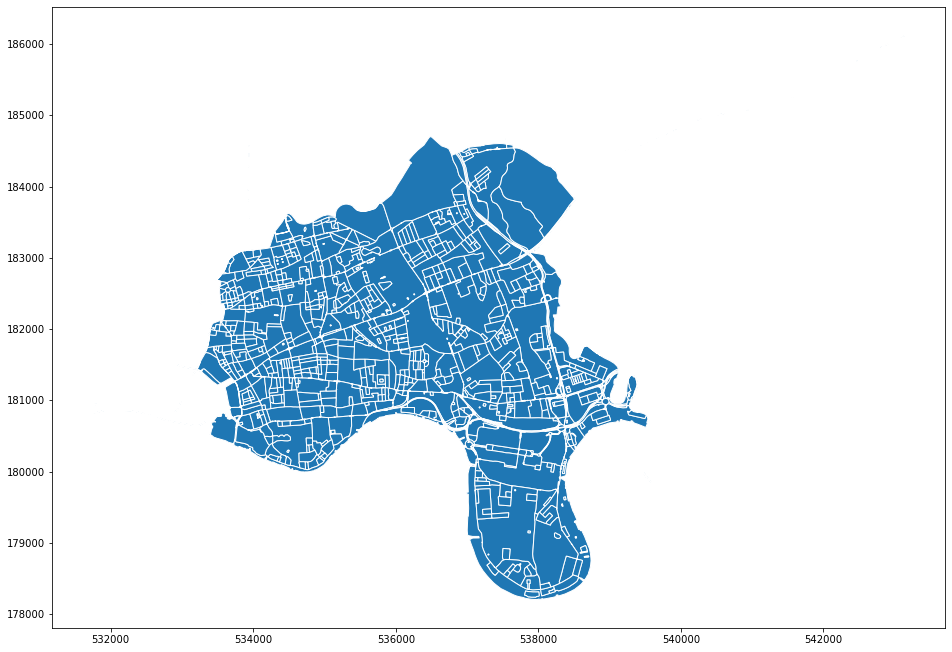

In [23]:
gpd.GeoSeries(enclosures).plot(figsize=(16, 16), edgecolor='w')

In [24]:
enclosures = mm.enclosures(roads, limit=gs)

C:\Users\liche\anaconda3\lib\site-packages\geopandas\array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as OSGB36 / British National Grid (the single non-null crs provided).
  warnings.warn(


In [25]:
enclosed_tess = mm.Tessellation(buildingsExtracted, unique_id='uID', enclosures=enclosures).tessellation

C:\Users\liche\anaconda3\lib\site-packages\momepy\elements.py:457: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  inp, res = buildings.sindex.query_bulk(
C:\Users\liche\anaconda3\lib\site-packages\geopandas\array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as OSGB36 / British National Grid (the single non-null crs provided).
  warnings.warn(


(179200.0, 179300.0)

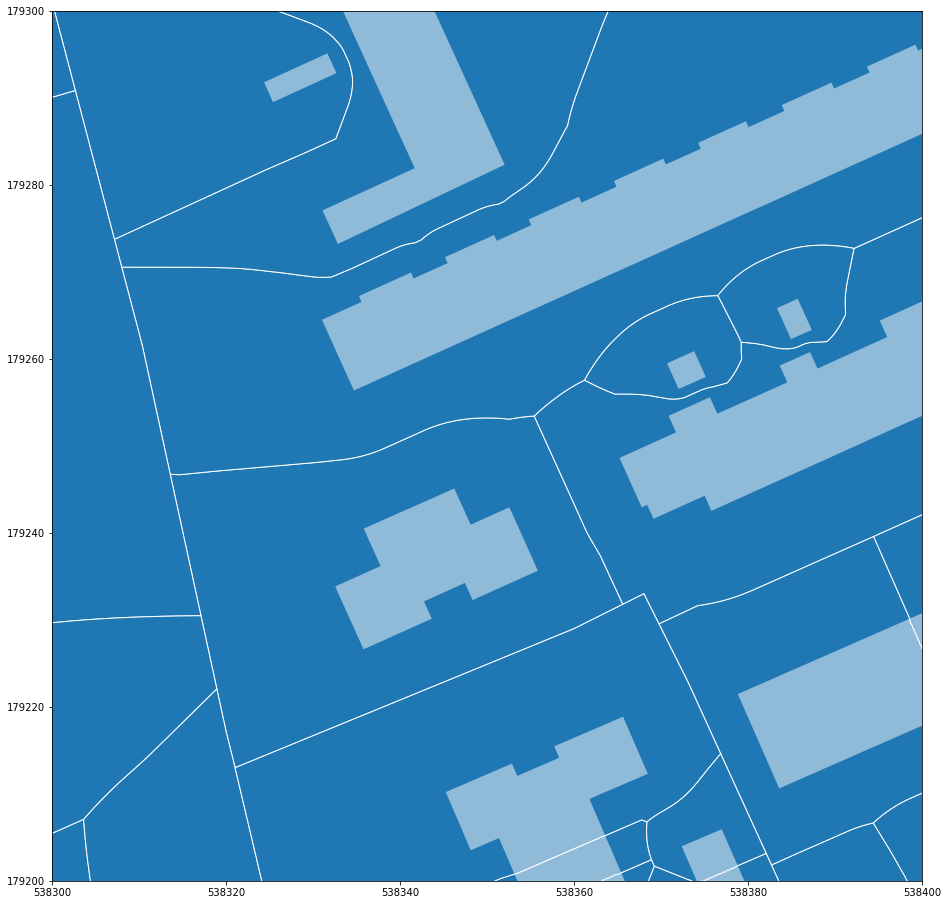

In [26]:
ax = enclosed_tess.plot(edgecolor='white', figsize=(16, 16))
buildingsExtracted.plot(ax=ax, color='white', alpha=.5)
#ax.set_axis_off()
ax.set_xlim(538300, 538400)
ax.set_ylim(179200, 179300)

In [40]:
valid_tess = enclosed_tess[(enclosed_tess['uID'] >= 0)]
valid_tess = valid_tess.drop_duplicates(subset=['uID'])
valid_buildings = buildingsExtracted[buildingsExtracted['uID'].isin(valid_tess['uID'])]

In [41]:
blocks = mm.Blocks(valid_tess, edges=roads, buildings=valid_buildings, id_name='bID', unique_id='uID')
blocks_df = blocks.blocks  # get blocks df
valid_buildings['bID'] = blocks.buildings_id.values  # get block ID
valid_tess['bID'] = blocks.tessellation_id.values  # get block ID

C:\Users\liche\anaconda3\lib\site-packages\momepy\elements.py:626: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  weights = libpysal.weights.Queen.from_dataframe(cut, silence_warnings=True)
C:\Users\liche\anaconda3\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [42]:
valid_tess.to_file('0302out/valid_tess.geojson', driver="GeoJSON")  
valid_buildings.to_file('0302out/valid_buildings.geojson', driver='GeoJSON')

In [43]:
limit.to_file('0302out/limit.geojson', driver="GeoJSON")

In [35]:
#extended = mm.extend_lines(roads, tolerance=120, target=gpd.GeoSeries([limit.boundary]), barrier=buildings)

GeometryTypeError: Unknown geometry type: 'featurecollection'

In [45]:
blocks_df.to_file('0302out/blocksDf.gpkg', layer='blocks', driver='GPKG')